# Tag Prediction for StackOverflow Posts - Multilabel Classification

We will predict tags for posts from [StackOverflow](https://stackoverflow.com) with linear models.

### Libraries

- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Pipeline
1. Text Preprocessing
2. Text Vectorization - BoW, Tf-idf
3. One Vs Rest Classifier Training
4. Evaluation - Accuracy, F1-score, AUROC, AP
5. Optimization 
   - Vectorization
   - Estimator Selection
   - Hyperparameter Tuning

### Text Preprocessing

Three data sets for training, validation and testing.

All corpora contain post titles from StackOverflow and tags (100 tags are available) except for *test*. 

The number of tags for a post is not fixed and could be as many as necessary. Thus, it is a multilabel classification task.

In [3]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np

def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

train.head(10)

In [5]:
# initialization
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

**Task 1 Text Preparation ** 

In [7]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        return: modified initial string
    """
    # 1. Lowercase text
    text = text.lower() 
    # 2. Replace '/', '()', '{}', '[]', '|', '@', ',', ';' by space
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    # 3. Delete the non-alphanumerics excluding '#', '+', '_'
    text = BAD_SYMBOLS_RE.sub('',text)
    # 4. Delete stopwords
    text_words = text.split()
    text_words = [t for t in text_words if t not in STOPWORDS]
    text = ' '.join(text_words)
    return text

# First, test it on a small case
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_text_prepare())

In [114]:
# Then, test it on a bigger case with 100 sentences
text_prepare_results = pd.read_csv('data/text_prepare_tests.tsv', header = None, sep='\t')
text_prepare_results.rename(columns = {0:'Original'}, inplace = True)
text_prepare_results['Prepared'] = text_prepare_results['Original'].apply(text_prepare)
text_prepare_results

In [117]:
# Save it to a tsv file to better check if all the texts are successfully processed.
text_prepare_results.to_csv('data/text_prepare_results.tsv', sep='\t')

After testing is finished, we can preprocess the titles in the data sets using function text_prepare.

In [10]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]
X_train[:10]

**Task 2 WordsTagsCount ** 

In [11]:
# Compute the occurances of each tag and word in the train corpus, i.e. {'word/tag': frequency}
from collections import defaultdict
tags_counts = defaultdict(int)
words_counts = defaultdict(int)
for labels in y_train:
    for tag in labels:
        tags_counts[tag] += 1
for sent in X_train:
    for word in sent.split():
        words_counts[word] += 1

# Find 3 most popular tags and 3 most popular words in the train data.
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)

### Transforming Text to Vector

#### Bag of words

1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

In [13]:
# Set the dictionary size 5000
DICT_SIZE = 5000
# Use train data to find the 5000 most common words
ALL_WORDS = sorted([x for x in words_counts.keys()], key=lambda x: words_counts[x], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {ALL_WORDS[x]: x for x in range(DICT_SIZE)}
INDEX_TO_WORDS = {x: ALL_WORDS[x] for x in range(DICT_SIZE)}

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        words_to_index: a list of words ordered by frequency
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector

# First test it on a small case
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_my_bag_of_words())

Now apply the implemented function to all samples (this might take up to a minute). We transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

In [15]:
from scipy import sparse as sp_sparse

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

In [17]:
# For the 11th row in *X_train_mybag* find how many non-zero elements it has.
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = sum(row != 0)
non_zero_elements_count

7

#### TF-IDF

It extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """

    # 1. Create TF-IDF vectorizer with a proper parameters choice
    
    # Filter out too rare words (occur less than in 5 titles) 
    # and too frequent words (occur more than in 90% of the titles). 
    # Use bigrams along with unigrams.
    # '(\S+)' matches any non-whitespace character
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df = 0.9, min_df = 5, token_pattern = '(\S+)')
    
    # 2. Fit the vectorizer on the train set
    # 3. Transform the train, test, and val sets and return the result
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results, because the performance of future models will drastically depend on it.

In [21]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

# Check if c++ or c# are in our vocabulary, as they are obviously important tokens in our tags prediction task.
tfidf_vocab['c#'], tfidf_vocab['c++']

### MultiLabel Classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

In [23]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [24]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [25]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    mlb_clf = OneVsRestClassifier(LogisticRegression())
    mlb_clf.fit(X_train, y_train)
    return mlb_clf

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [26]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [27]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [34]:
y_val_predicted_scores_mybag[:10]

array([[ -3.57333854,  -5.40535768,  -5.8563761 ,  -3.58218358,
         -4.94420628,  -6.15913867,  -5.6840656 ,  -2.89216017,
         -5.03064451,  -3.70003706,  -1.0338071 ,  -2.88596423,
         -6.72166585,  -5.29443692,  -5.98761993,  -5.29171378,
         -7.35216875,  -4.97241912,  -6.55103344,  -6.06368965,
         -5.25047179,  -5.81711271,  -5.14611721,  -5.53974294,
         -7.92856649,  -6.85757949,  -5.82682005,  -6.09791403,
         -7.04633273,  -6.62150369,  -7.2420952 ,  -5.44081946,
         -4.19447141,  -4.58681795,  -5.47350139,  -3.39853886,
         -2.95229668,  -1.66051432,  -3.05979635,  -4.17494814,
         -5.19651909,  -6.0165206 ,  -6.63085418,  -5.73334577,
         -4.4653379 ,  -5.94186588,  -6.88394539,  -6.24929203,
         -6.44882119,  -4.61560853,  -4.80670971,  -5.76642122,
         -5.75591137,  -3.19705786,  -5.96048586,  -5.25361676,
         -5.72012052,  -6.46092795,  -6.36970295,  -5.32810359,
         -2.26671462,  -6.40411044,  -2.

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [28]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 The labels predicted for a sample must exactly match the corresponding set of true labels.
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
   * Precision: not to label a negative sample as positive
   * Recall: to find all the positive samples
   * F1 = 2 * (precision * recall) / (precision + recall)
   
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [30]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print('Accuracy Score: {:.4f}'.format(accuracy_score(y_val, predicted)))
    print('F1-score macro/micro/weighted: {:.4f}, {:.4f}, {:.4f}'.format(f1_score(y_val, predicted,average='macro'),
          f1_score(y_val, predicted,average='micro'),
          f1_score(y_val, predicted,average='weighted')))
    print('Precision macro/micro/weighted: {:.4f}, {:.4f}, {:.4f}'.format(average_precision_score(y_val,predicted, average='macro'),
          average_precision_score(y_val,predicted, average='micro'),
          average_precision_score(y_val,predicted, average='weighted')))

In [77]:
print('asdf \n{:.4f}\n {:.2f}, {:.2f}'.format(5,8,9))

asdf 
5.0000
 8.00, 9.00


In [31]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy Score: 0.3580
F1-score macro/micro/weighted: 0.5047, 0.6711, 0.6487
Precision macro/micro/weighted: 0.5617, 0.7085, 0.6976
Tfidf
Accuracy Score: 0.3339
F1-score macro/micro/weighted: 0.4457, 0.6418, 0.6144
Precision macro/micro/weighted: 0.5420, 0.7017, 0.6885


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [85]:
from metrics import roc_auc
%matplotlib inline

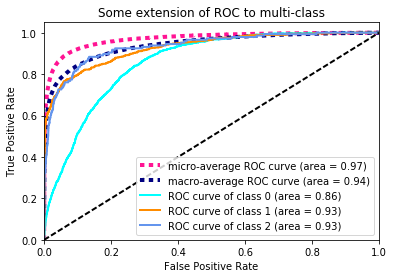

In [86]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

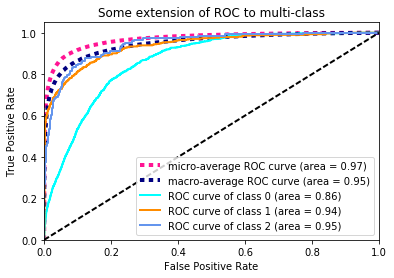

In [87]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [ ]:
test_predictions = ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weights in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [76]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    tag_est = classifier.estimators_[tags_classes.index(tag)]
    word_sorted_index = tag_est.coef_.reshape(-1).argsort()
    top_positive_words = [index_to_words[x] for x in word_sorted_index[:-6:-1]] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[x] for x in word_sorted_index[:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [77]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	javascript, c#, jquery, array, method

